In [1]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

# Inference in Pyro: From Stochastic Functions to Marginal Distributions

Stochastic functions induce a joint probability distribution $p(y, z \; \vert \; x)$ over their latent variables $z$ and return values $y$, and this joint distribution induces a marginal distribution over return values of the function. However, for non-primitive stochastic functions, we can no longer explicitly compute the marginal probability of an output $p(y \; \vert \; x)$ or draw samples from the marginal distribution over return values $y \sim p (y \; \vert \; x)$.

In its most general formulation, *inference* in a universal probabilistic programming language like Pyro is the problem of constructing this marginal distribution given an arbitrary boolean constraint so that we can perform these computations. The constraint can be a deterministic function of the return value, the internal randomness, or both.

*Bayesian inference* or *posterior inference* is an important special case of this more general formulation that admits tractable approximations. In Bayesian inference, the return value is always the values of some subset internal `sample` statements, and the constraint is an equality constraint on the other internal `sample` statements.  Much of modern machine learning can be cast as approximate Bayesian inference and expressed succinctly in a language like Pyro.

To motivate the rest of this tutorial, let's first build a generative model for a simple physical problem so that we can use Pyro's inference machinery to solve it.

## A Simple Example

Suppose we are trying to figure out how much something weighs, but the scale we're using is unreliable and gives slightly different answers every time we weigh the same object.  We could try to compensate for this variability by integrating the noisy measurement information with a guess based on some prior knowledge about the object, like its density or material properties.  The following model encodes this process:

In [2]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

## Representing Marginal Distributions

Before we actually try using our model to estimate an object's weight, let's try analyzing our model's behavior.  In particular, we can use importance sampling to simulate the marginal distribution of measurement values we'd expect to see a priori for a given guess.

Marginalization in Pyro with `pyro.infer.EmpiricalMarginal` is split into two steps. First, we collect a number of weighted execution traces of the model. Then, we can collapse those traces into a histogram over possible return values given a particular set of arguments.

Collecting execution traces can be done either through sampling or, for models with only discrete latent variables, exact enumeration.  To create a basic importance sampler over execution traces (using the prior as the proposal distribution), we can write:

In [3]:
posterior = pyro.infer.Importance(scale, num_samples=100)

`posterior` is not a particularly useful object on its own.  Instead, the output of `posterior` (computed with `posterior.run`, which runs inference for a single input value) is meant to be consumed by `pyro.infer.EmpiricalMarginal`, which creates a primitive stochastic function with the same output types as `scale`.  

In [4]:
guess = 8.5

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())

tensor(8.0281)


When called with an input `guess`, `marginal` first uses `posterior` to generate a sequence of weighted execution traces given `guess`, then builds a histogram over return values from the traces, and finally returns a sample drawn from the histogram.  Calling `marginal` with the same arguments more than once will sample from the same histogram.

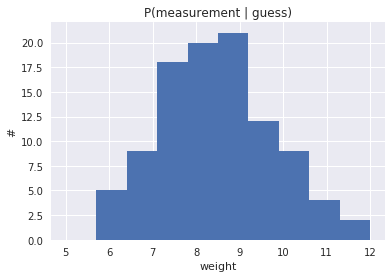

In [5]:
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

`pyro.infer.EmpiricalMarginal` also accepts the optional keyword argument `sites=name` that provides a name of a latent variable.  When `sites` is specified, `marginal` will compute the marginal distribution of that site, rather than of the return value.  This is useful because we may wish to compute many different marginals from the same posterior object.

## Conditioning Models on Data

The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data. In Pyro, we separate the expression of conditioning from its evaluation via inference, making it possible to write a model once and condition it on many different observations.  Pyro supports constraining a model's internal `sample` statements to be equal to a given set of observations.

Consider `scale` once again.  Suppose we want to sample from the marginal distribution of `weight` given input `guess = 8.5`, but now we have observed that `measurement == 9.5`.  Pyro provides the function `pyro.condition` to allow us to constrain the values of sample statements.  `pyro.condition` is a higher-order function that takes a model and a dictionary of data and returns a new model that has the same input and output signatures but always uses the given values at observed `sample` statements:

In [6]:
conditioned_scale = pyro.condition(
    scale, data={"measurement": 9.5})

Because it behaves just like an ordinary Python function, conditioning can be deferred or parametrized with Python's `lambda` or `def`:

In [7]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

In some cases it might be more convenient to pass observations directly to individual `pyro.sample` statements instead of using `pyro.condition`.  The optional `obs` keyword argument is reserved by `pyro.sample` for that purpose:

In [8]:
# equivalent to pyro.condition(scale, data={"measurement": torch.tensor([9.5])})
def scale_obs(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we attach an observation measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.),
                       obs=9.5)

However, hardcoding is not usually recommended due to its invasive non-compositional nature.  By contrast, using `pyro.condition`, conditioning may be composed freely to form multiple complex queries on probabilistic models without modifying the underlying model.  The only restriction is that a single site may only be constrained once.

In [9]:
def scale2(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0., 1.)))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))

# conditioning composes: 
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": 9.2}), 
    data={"measurement": 9.5})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": 9.5}), 
    data={"weight": 9.2})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": 9.2, "measurement": 9.5})

In addition to `pyro.condition` for incorporating observations, Pyro also contains `pyro.do`, an implementation of Pearl's `do`-operator used for causal inference with an identical interface to `pyro.condition`.  `condition` and `do` can be mixed and composed freely, making Pyro a powerful tool for model-based causal inference.  See the [causal inference tutorial](http://pyro.ai/examples/causal_inference.html) for more details about `pyro.do` and a simple example of causal inference in a model of disease diagnosis.

## Flexible Approximate Inference With Guide Functions

Let's return to `deferred_conditioned_scale`.  Now that we have constrained `measurement` against some data, we can use Pyro's approximate inference algorithms to estimate the distribution over `weight` given `guess` and `measurement == data`.  We saw earlier how to use importance sampling to do this for `scale`; we can use exactly the same constructs with a conditioned model:

tensor(8.1581)


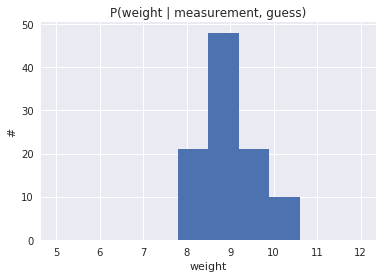

In [10]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight")

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

However, this approach is extremely computationally inefficient because the prior distribution over `weight` may be very far from the true distribution over weights, especially if our initial `guess` is not very good.

Therefore, some inference algorithms in Pyro, like `pyro.infer.Importance` and `pyro.infer.SVI`, allow us to use arbitrary stochastic functions, which we will call *guide functions* or *guides*, as approximate posterior distributions.  Guide functions must satisfy these two criteria to be valid approximations for a particular model: 
1. all unobserved sample statements that appear in the model appear in the guide.
2. the guide has the same input signature as the model (i.e. takes the same arguments)

Guide functions can serve as programmable, data-dependent proposal distributions for importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metropolis-Hastings, and as variational distributions or inference networks for stochastic variational inference.  Currently, only importance sampling and stochastic variational inference are implemented in Pyro, but we plan to add other algorithms in the future.

Although the precise meaning of the guide is different across different inference algorithms, the guide function should generally be chosen so that it closely approximates the distribution over all unobserved `sample` statements in the model.  The simplest guide for `deferred_conditioned_scale` matches the prior distribution over `weight`:

In [11]:
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.Normal(guess, 1.))

posterior = pyro.infer.Importance(conditioned_scale, 
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

Can we do better than the prior?  In the case of `scale`, it turns out that the true posterior distribution over `weight` given `guess` and `measurement` can be written directly as:

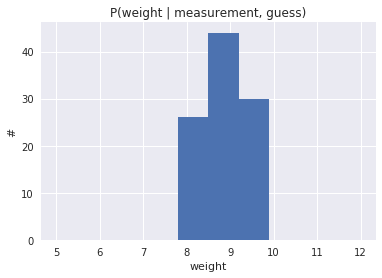

In [13]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.Normal(a, b))

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="weight")
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

## Parametrized Stochastic Functions and Variational Inference

Although we could write out the exact posterior distribution for `scale`, in general it is intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function.  What we can do instead is use the top-level function `pyro.param` to specify a *family* of guides indexed by named parameters, and search for the member of that family that is the best approximation.  This approach to approximate posterior inference is called *variational inference*.

`pyro.param` is a frontend for Pyro's key-value *parameter store*, which is described in more detail in the documentation. Like `pyro.sample`, `pyro.param` is always called with a name as its first argument.  The first time `pyro.param` is called with a particular name, it stores its argument in the parameter store and then returns that value.  After that, when it is called with that name, it returns the value from the parameter store regardless of any other arguments.  It is similar to `simple_param_store.setdefault` here, but with some additional tracking and management functionality.

```python
simple_param_store = {}
a = simple_param_store.setdefault("a", torch.randn(1))
```

For example, we can parametrize `a` and `b` in `scale_posterior_guide` instead of specifying them by hand:

In [16]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

Pyro is built to enable *stochastic variational inference*, a powerful and widely applicable class of variational inference algorithms with three key characteristics: 
1. Parameters are always real-valued tensors
2. We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide
3. We use stochastic gradient descent to search for the optimal parameters.  

Combining stochastic gradient descent with PyTorch's GPU-accelerated tensor math and automatic differentiation allows us to scale variational inference to very high-dimensional parameter spaces and massive datasets.  

Pyro's SVI functionality is described in detail in the [SVI tutorial](http://pyro.ai/examples/svi_part_i.html). Here is a very simple example applying it to `scale`:

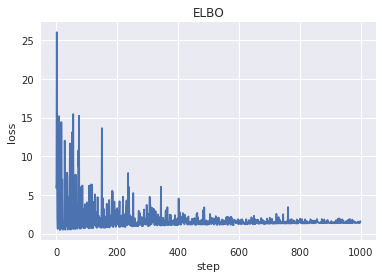

In [17]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, 
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
for t in range(1000):
    losses.append(svi.step(guess))
    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

Note that optimization will update the guide parameters, but does not produce a posterior distribution object itself. Once we find good parameter values, we can just use the guide as a representation of the model's approximate posterior for downstream tasks.

For example, we can use the optimized guide as an importance distribution for estimating the marginal distribution over `weight` with many fewer samples than the prior:

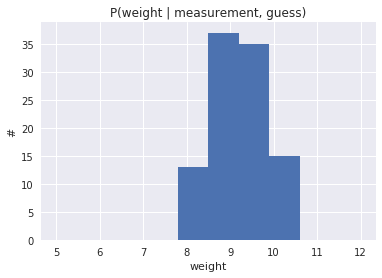

In [18]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

We can also sample from the guide directly as an approximate posterior:

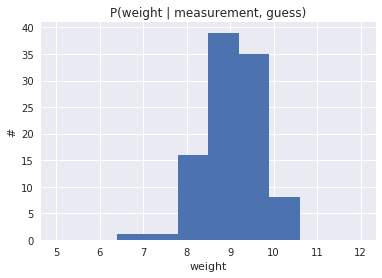

In [21]:
plt.hist([scale_parametrized_guide(guess).item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

## Next Steps

In the [Variational Autoencoder tutorial](http://pyro.ai/examples/vae.html), we'll see how models like `scale` can be augmented with deep neural networks and use stochastic variational inference to build a generative model of images.